In [1]:
from lsqecc.logical_lattice_ops import logical_lattice_ops
from lsqecc.patches.patches import PatchType
from lsqecc.patches.ancilla_region_routing import make_graph_of_free_cells, make_tuple, AncillaRegionRoutingException
from lsqecc.pipeline.lattice_surgery_compilation_pipeline import compile_str
from lsqecc.simulation.logical_patch_state_simulation import SimulatorType

/Users/jviszlai/Documents/Work/Research/ProjectRepos/swiper/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


#### pyLIQTR Carleman Encoding

In [2]:
import math
import numpy as np
from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran import Register, Signature, QAny

from pyLIQTR.BlockEncodings.CarlemanLinearization   import Carleman_Linearization
from pyLIQTR.ProblemInstances.NonlinearODE          import FOperators
from pyLIQTR.utils.circuit_decomposition            import circuit_decompose_multi

import cirq

In [3]:
n = 2
K = 4

a0_in = n
a1 = n
a2_in = math.ceil(n/2)
a2_out = math.ceil(n)

alpha0 = 1
alpha1 = 1
alpha2 = 1

In [4]:
ancilla_register = Register("ancilla", QAny(bitsize = 7 + max(a0_in, a1, a2_in, a2_out) + math.ceil(np.log2(K))))
data_register = Register("data", QAny(bitsize = n*K+1))

signature = Signature([ancilla_register, data_register])
registers = get_named_qubits(signature)

In [5]:
carlemanLinearization = Carleman_Linearization(FOperators(n, K, (a0_in, a1, a2_in, a2_out), (alpha0, alpha1, alpha2)), K)
circuit = cirq.Circuit(carlemanLinearization.on_registers(**registers))


### Lattice Surgery Schedule

In [6]:
from benchmarks.cirq_to_ls import cirq_to_ls
from swiper2.simulator import DecodingSimulator
import matplotlib.pyplot as plt
import swiper2.plot as plotter

In [7]:
ls_schedule = cirq_to_ls(circuit_decompose_multi(circuit, 6)[:200])

LS Instructions read  1458
Slices 261
Made patch computation. Took 0.120698s.
LS Instructions read  1458
Slices 261
Made patch computation. Took 0.423889s.


In [8]:
d=7
decoding_time = 0
speculation_time = 0
speculation_accuracy = 1

simulator = DecodingSimulator(d, lambda _: decoding_time, speculation_time, speculation_accuracy, speculation_mode='integrated')

In [9]:
%%prun
success, device_data, window_data, decoding_data = simulator.run(
    schedule=ls_schedule,
    scheduling_method='sliding',
    enforce_window_alignment=False,
    max_parallel_processes=None,
    progress_bar=True,
    save_animation_frames=False
)

Surface code rounds: 1386it [00:54, 25.64it/s]

         123408454 function calls (104440923 primitive calls) in 32.377 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 46455292   13.302    0.000   32.505    0.000 <string>:2(__eq__)
28374643/9564204    3.226    0.000    7.495    0.000 {built-in method builtins.hash}
    28678    2.683    0.000   35.188    0.001 {method 'index' of 'list' objects}
     1387    2.566    0.002    6.017    0.004 device_manager.py:93(_predict_instruction_start_times)
  9528976    1.744    0.000    9.222    0.000 <string>:2(__hash__)
  4401481    1.299    0.000    1.530    0.000 device_manager.py:85(_is_startup_instruction)
        2    1.070    0.535    1.166    0.583 lattice_surgery_schedule.py:136(to_dag)
     1386    0.586    0.000   36.435    0.026 decoder_manager.py:128(update_decoding)
     1386    0.510    0.000    2.792    0.002 decoder_manager.py:199(get_finished_instruction_indices)
  4641551    0.446    0.000    0.588    0.000 enum.

<Axes3D: >

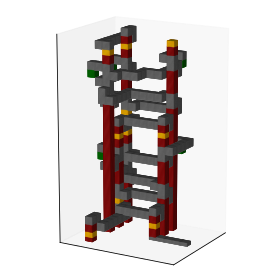

In [14]:
plotter.plot_device_schedule_trace(device_data, hide_z_ticks=True, z_min=1200, z_max=1400)